# Convolutional Neural Network for Multi-class Classification

In [1]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

## Prepare Images CSV for ImageDataGenerator

Download the Data Set:
Train: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
Test: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

In [2]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

with open(TRAINING_FILE) as training_file:
    line = training_file.readline()
    print(f"First line (header) looks like this:\n{line}")
    line = training_file.readline()
    print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

In [3]:
def parse_data_from_input(filename):
    """
    Parses the images and labels from a CSV file
    Args:
    filename (string): path to the CSV file
    Returns:
    images, labels: tuple of numpy arrays containing the images and labels
    """
    with open(filename, 'r') as file_:
        csv_reader = csv.reader(file_, delimiter=',')
        next(csv_reader)
        labels = []
        images = []
        for row in csv_reader:
            label = row[0]
            image = row[1:]
            image = np.array([image]).reshape((28,28))
            labels.append(label)
            images.append(image)

        labels = np.array(labels).astype('float')
        images = np.array(images).astype('float')
        return images, labels

In [5]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")
print(validation_labels[:10])

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64
[ 6.  5. 10.  0.  3. 21. 10. 14.  3.  7.]


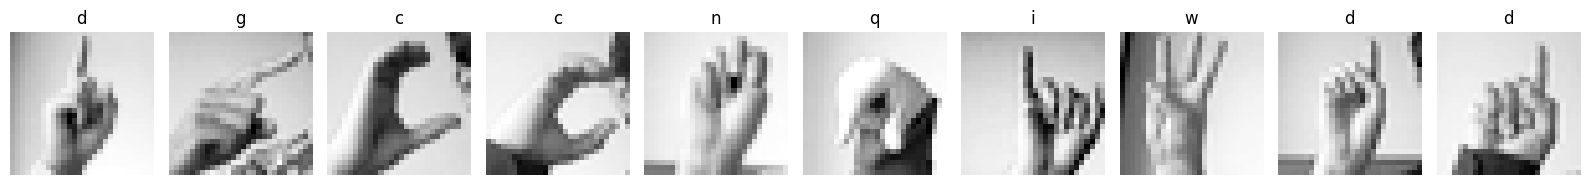

In [9]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
    fig, axes = plt.subplots(1, 10, figsize=(16, 15))
    axes = axes.flatten()
    letters = list(string.ascii_lowercase)

    for k in range(10):
        img = training_images[k]
        img = np.expand_dims(img, axis=-1)
        img = array_to_img(img)
        ax = axes[k]
        ax.imshow(img, cmap="Greys_r")
        ax.set_title(f"{letters[int(training_labels[k])]}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

plot_categories(training_images, training_labels)

## ImageDataGenerator: Batches of tensor image data with real-time data augmentation

In this case the images in this dataset come in the same resolution, so there is no need to set a custom target_size. In fact, we can't do that with the train_datagen.flow() method.

In [12]:
from numpy.core.fromnumeric import reshape

def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    """
    Creates the training and validation data generators
    Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file
    Returns:
    train_generator, validation_generator - tuple containing the generators
    """
    training_images = np.expand_dims(training_images, axis=-1) # Add RGB dim (10000, 28, 28) to (10000, 28, 28, 1)
    validation_images = np.expand_dims(validation_images, axis=-1)

    # Instantiate the ImageDataGenerator class
    train_datagen = ImageDataGenerator(rescale = 1/255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    # train_datagen.flow method
    train_generator = train_datagen.flow(x=training_images,
                                         y=training_labels,
                                         batch_size=32)

    # Instantiate the ImageDataGenerator class
    validation_datagen = ImageDataGenerator(rescale = 1/255)

    # train_datagen.flow method
    validation_generator = validation_datagen.flow(x=validation_images,
                                                   y=validation_labels,
                                                   batch_size=32)

    return train_generator, validation_generator

In [14]:
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

## Model

In [17]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(26, activation='softmax')
        ])

    model.compile(loss='sparse_categorical_crossentropy', # Categorical_crossentropy is for one-hot-encoded labels
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [18]:
# Instantiate the model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=validation_generator)

Epoch 1/5
858/858 [==============================] - 26s 29ms/step - loss: 2.8035 - accuracy: 0.1528 - val_loss: 1.9627 - val_accuracy: 0.3645
Epoch 2/5
858/858 [==============================] - 24s 28ms/step - loss: 2.1234 - accuracy: 0.3341 - val_loss: 1.7524 - val_accuracy: 0.4306
Epoch 3/5
858/858 [==============================] - 24s 27ms/step - loss: 1.6867 - accuracy: 0.4608 - val_loss: 0.9850 - val_accuracy: 0.6378
Epoch 4/5
858/858 [==============================] - 22s 25ms/step - loss: 1.3906 - accuracy: 0.5485 - val_loss: 0.8740 - val_accuracy: 0.7001
Epoch 5/5
858/858 [==============================] - 22s 25ms/step - loss: 1.1960 - accuracy: 0.6104 - val_loss: 0.6490 - val_accuracy: 0.7876


## Accuracy and Loss

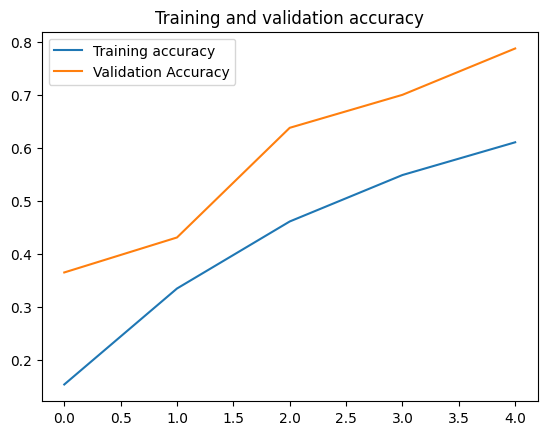

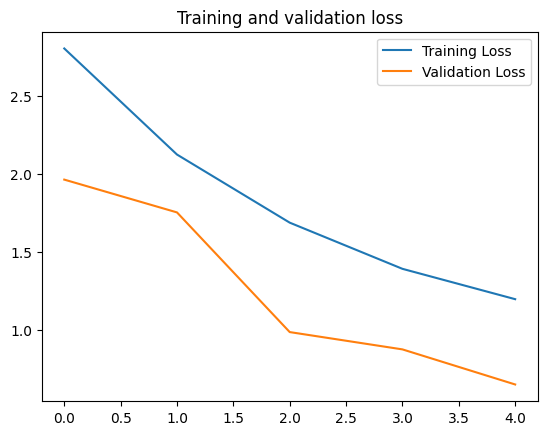

In [20]:
def plot_acc_val(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss' ]
    epochs = range(len(acc)) # Get number of epochs

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_acc_val(history)